2025/05/13 20:01:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CV RMSE: 68.93, Test RMSE: 70.24


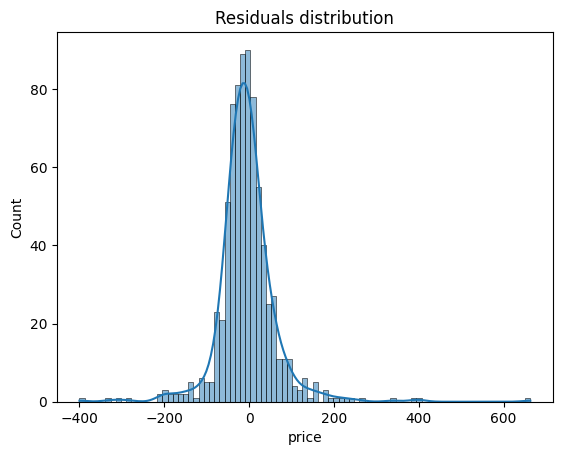

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1️⃣ Adatok beolvasása
df = pd.read_csv("../data/listings.csv")

# 2️⃣ Egyszerűsített adatpucolás
df = df[['price', 'bedrooms', 'bathrooms', 'accommodates', 'number_of_reviews']].dropna()
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# 3️⃣ Feature / target szeparálás
X = df.drop('price', axis=1)
y = df['price']

# 4️⃣ Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5️⃣ MLflow experiment indítása
mlflow.set_experiment("airbnb-price-sklearn")
with mlflow.start_run():
    # Modell definiálása
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Keresztvalidáció
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_cv = -np.mean(cv_scores)

    # Modell fit
    model.fit(X_train, y_train)

    # Teszt RMSE
    preds = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, preds) ** 0.5

    # Log metrikák
    mlflow.log_metric("rmse_cv", rmse_cv)
    mlflow.log_metric("rmse_test", rmse_test)

    # Log modell
    mlflow.sklearn.log_model(model, "random_forest_model")

    print(f"CV RMSE: {rmse_cv:.2f}, Test RMSE: {rmse_test:.2f}")

    joblib.dump(model, "../models/final_model.pkl")

# 6️⃣ Eredmények vizualizálása
sns.histplot(y_test - preds, kde=True)
plt.title("Residuals distribution")
plt.show()